## Importing Libraries

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold

## Importing data with improvements

In [2]:
if __name__ == "__main__":
    # Load the MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Reshape the data to a 2D array for the classifier
    x_train = x_train.reshape(60000, 784)   #28 * 28 = 784
    x_test = x_test.reshape(10000, 784)

11501568/11490434 [==============================] - 3s 0us/step


In [3]:
# Remove features with zero variance
sel = VarianceThreshold()
x_train = sel.fit_transform(x_train)
x_test = sel.transform(x_test)

## Forward Selection

In [4]:
def forwad_selection(x_train, y_train, x_test, y_test):
    """
    This function performs forward feature selection to select the best features for the Naive Bayes classifier.
    """
    # Initialize an empty set to hold the selected features
    selected_features = set()

    # Define the number of features to select
    num_features = 40

    # Initialize lists to hold the accuracy and number of selected features
    accuracy_list = []
    num_selected_features_list = []

    # Loop until the desired number of features have been selected
    for i in range(num_features):
        best_accuracy = 0
        best_feature = None
        
        # For each feature in the dataset, train a Naive Bayes classifier using that feature along with the features already selected, and evaluate its performance on the validation set
        for feature in range(x_train.shape[1]):
            if feature not in selected_features:
                features = list(selected_features) + [feature]
                nb_model = train_nb_classifier(x_train, y_train, features)
                x_val_subset = x_test[:, features]
                accuracy = nb_model.score(x_val_subset, y_test)
                
                # Choose the feature that gives the best performance
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_feature = feature
        
        # Add the selected feature to the set and remove it from the feature pool
        selected_features.add(best_feature)
        
        # Print the selected feature and its validation accuracy
        print(f"Selected feature {i+1}: {best_feature}, validation accuracy: {best_accuracy}")
        
        nb_model = train_nb_classifier(x_train, y_train, list(selected_features))
        x_test_subset = x_test[:, list(selected_features)]
        accuracy = nb_model.score(x_test_subset, y_test)
        
        # Append the accuracy and number of selected features to the lists
        accuracy_list.append(accuracy)
        num_selected_features_list.append(len(selected_features))
        
    # Train a final classifier using the selected features and evaluate its performance on the test set
    selected_features = list(selected_features)
    nb_model = train_nb_classifier(x_train, y_train, selected_features)
    x_test_subset = x_test[:, selected_features]
    accuracy = nb_model.score(x_test_subset, y_test)
    print(f"Final accuracy on the test set using {num_features} features: {accuracy}")
    
    return selected_features, accuracy_list, num_selected_features_list

## Model and Training

In [7]:
def train_nb_classifier(x_train, y_train, features):
    """
    This function trains a Naive Bayes classifier using a subset of features.
    """
    # Select the subset of features from the training set
    x_train_subset = x_train[:, features]
    
    # Initialize the Naive Bayes model with a small variance smoothing
    nb_model = GaussianNB(var_smoothing=1e-9)
    
    # Fit the model to the training data
    nb_model.fit(x_train_subset, y_train)
    
    return nb_model


In [8]:
# Perform forward feature selection
selected_features, accuracy_list, num_selected_features_list = forwad_selection(x_train, y_train, x_test, y_test)

Selected feature 1: 391, validation accuracy: 0.2273
Selected feature 2: 366, validation accuracy: 0.3363
Selected feature 3: 220, validation accuracy: 0.4094
Selected feature 4: 498, validation accuracy: 0.4667
Selected feature 5: 307, validation accuracy: 0.5209
Selected feature 6: 255, validation accuracy: 0.5592
Selected feature 7: 168, validation accuracy: 0.591
Selected feature 8: 609, validation accuracy: 0.6226
Selected feature 9: 331, validation accuracy: 0.6419
Selected feature 10: 551, validation accuracy: 0.6649
Selected feature 11: 414, validation accuracy: 0.6902
Selected feature 12: 225, validation accuracy: 0.7057
Selected feature 13: 472, validation accuracy: 0.7204
Selected feature 14: 506, validation accuracy: 0.7357
Selected feature 15: 257, validation accuracy: 0.7439
Selected feature 16: 362, validation accuracy: 0.7524
Selected feature 17: 110, validation accuracy: 0.7601
Selected feature 18: 329, validation accuracy: 0.7687
Selected feature 19: 276, validation a

## Visualization

In [9]:

def plot_CCR(num_selected_features_list, accuracy_list):
    """
    This function plots the correct classification rate as a function of the number of selected features.
    """
    plt.plot(num_selected_features_list, accuracy_list)
    plt.xlabel("Number of selected features")
    plt.ylabel("Correct classification rate")
    plt.title("Optimal number of features")
    plt.show()

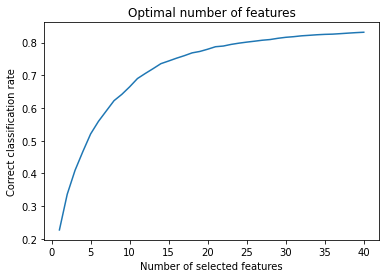

In [10]:
plot_CCR(num_selected_features_list, accuracy_list)

### Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

# Predict the test set results
y_pred = nb_model.predict(x_test_subset)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

NameError: name 'nb_model' is not defined

### ROC Curve

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

# Binarize the output
y = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(nb_model)
y_score = classifier.fit(x_train_subset, y_train).predict_proba(x_test_subset)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic example')
    plt.legend(loc="lower right")
    plt.show()